# Zee Recommender System

## Business problem:

Create a Recommender System to show personalized movie recommendations based on ratings given by a user and other users similar to them in order to improve user experience.

## Data Dictionary:

### 1. Ratings data

All ratings are contained in the file "ratings.dat" and are in the following format.

  **UserID::MovieID::Rating::Timestamp**

- UserIDs range between 1 and 6040
- MovieIDs range between 1 and 3952
- Ratings are made on a 5-star scale (whole-star ratings only)
- Timestamp is represented in seconds
- Each user has at least 20 ratings

### 2. Users data 

User information is in the file "users.dat" and is in the following format:

  **UserID::Gender::Age::Occupation::Zip-code**

All demographic information is provided voluntarily by the users and is not checked for accuracy.
Only users who have provided some demographic information are included in this data set.

- Gender is denoted by a "M" for male and "F" for female
- Age is chosen from the following ranges:
    - 1: "Under 18"
    - 18: "18-24"
    - 25: "25-34"
    - 35: "35-44"
    - 45: "45-49"
    - 50: "50-55"
    - 56: "56+"

Occupation is chosen from the following choices:

- 0: "other" or not specified
- 1: "academic/educator"
- 2: "artist"
- 3: "clerical/admin"
- 4: "college/grad student"
- 5: "customer service"
- 6: "doctor/health care"
- 7: "executive/managerial"
- 8: "farmer"
- 9: "homemaker"
- 10: "K-12 student"
- 11: "lawyer"
- 12: "programmer"
- 13: "retired"
- 14: "sales/marketing"
- 15: "scientist"
- 16: "self-employed"
- 17: "technician/engineer"
- 18: "tradesman/craftsman"
- 19: "unemployed"
- 20: "writer"

### 3. Movies data 

Movie information is in the file "movies.dat" and is in the following format:

  **MovieID::Title::Genres**

Titles are identical to titles provided by the IMDB (including year of release)

Genres are pipe-separated and are selected from the following genres:

- Action
- Adventure
- Animation
- Children's
- Comedy
- Crime
- Documentary
- Drama
- Fantasy
- Film-Noir
- Horror
- Musical
- Mystery
- Romance
- Sci-Fi
- Thriller
- War
- Western


**Additional view:**

In this case study, we will explore different recommendation approaches. We start by data processing and feature extraction to create item(movie) profile, user profile, and utility (user-movie-ratings) matrices. We then define several helper functions to compute item-item and user-user similarity matrices based on Cosine distance, dot product, and Pearson correlation. We also define helper function to find similar similar items and users based on the given similarity measure. Finally, we define and evaluate different recommendation approaches such as item based, collaborative filtering using matrix factorization, and user based recommendations. 

# Solution

## Import data and check basic characteristics

In [1]:
#common imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#mount google drive
#from google.colab import drive
#drive.mount('/content/drive')

import os, sys
#from google.colab import drive
#drive.mount('/content/drive')
nb_path = '/content/notebooks'

try:
  if(os.path.islink(nb_path)):
    #os.unlink(nb_path)
    pass;
  else:
    os.symlink('/content/drive/My Drive/Colab Notebooks/zee_rec_packages', nb_path)
    
except BaseException as error: 
    print(error)

if(nb_path not in sys.path):
  sys.path.insert(0,nb_path)

#!pip install --target=$nb_path cmfrec

about to create symlink


In [3]:
#read data
movies = pd.read_csv("drive/MyDrive/Scaler-case-studies/Zee-recommender-system/data/zee-movies.dat", engine='python', sep="::", encoding = "ISO-8859-1")
users = pd.read_csv("drive/MyDrive/Scaler-case-studies/Zee-recommender-system/data/zee-users.dat", engine='python', sep="::", encoding = "ISO-8859-1")
ratings = pd.read_csv("drive/MyDrive/Scaler-case-studies/Zee-recommender-system/data/zee-ratings.dat", engine='python', sep="::", encoding = "ISO-8859-1")

In [4]:
print('movies:', movies.shape)
print('users:', users.shape)
print('ratings:', ratings.shape)

movies: (3883, 3)
users: (6040, 5)
ratings: (1000209, 4)


In [5]:
movies.head(3)

,Movie ID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


In [6]:
users.head(3)

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117


In [7]:
ratings.head(3)

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968


In [8]:
#rename 'Movie ID' to 'MovieID' for consistency. 
movies.rename(columns={'Movie ID': 'MovieID'}, inplace=True)

In [9]:
#missing value check
print(movies.isna().sum())
print(users.isna().sum())
print(ratings.isna().sum())

MovieID    0
Title      0
Genres     0
dtype: int64
UserID        0
Gender        0
Age           0
Occupation    0
Zip-code      0
dtype: int64
UserID       0
MovieID      0
Rating       0
Timestamp    0
dtype: int64


In [10]:
print('Total number of unique movies: ', movies['MovieID'].nunique())
print('Total number of rated movies (rated by atleast one user): ', ratings['MovieID'].nunique())
print('Total number of unrated movies: ', movies['MovieID'].nunique() - ratings['MovieID'].nunique())

Total number of unique movies:  3883
Total number of rated movies (rated by atleast one user):  3706
Total number of unrated movies:  177


In [11]:
print('Total number of unique users: ', users['UserID'].nunique())
print('Total number of active users (who have rated atleast one movie): ', ratings['UserID'].nunique())
print('Total number of inactive users: ', users['UserID'].nunique() - ratings['UserID'].nunique())

Total number of unique users:  6040
Total number of active users (who have rated atleast one movie):  6040
Total number of inactive users:  0


## Data preprocessing and EDA

### movies data

In [12]:
movies.head(5)

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [13]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   MovieID  3883 non-null   int64 
 1   Title    3883 non-null   object
 2   Genres   3883 non-null   object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB


In [14]:
#extract release_year as a feature
movies['release_year'] = movies['Title'].str.strip().str.extract(r'^.+\((?P<release_year>[0-9]+)\)$').astype('int')
movies['release_year'].value_counts()

1996    345
1995    342
1998    337
1997    315
1999    283
       ... 
1923      3
1919      3
1922      2
1920      2
1921      1
Name: release_year, Length: 81, dtype: int64

In [15]:
#check for any missing values
movies['release_year'].isna().sum()

0

In [16]:
movies['Genres']

0        Animation|Children's|Comedy
1       Adventure|Children's|Fantasy
2                     Comedy|Romance
3                       Comedy|Drama
4                             Comedy
                    ...             
3878                          Comedy
3879                           Drama
3880                           Drama
3881                           Drama
3882                  Drama|Thriller
Name: Genres, Length: 3883, dtype: object

In [17]:
m = movies.copy()
m['Genres'] = movies['Genres'].str.split("|")
m = m.drop(['Genres'],axis=1).merge(m['Genres'].explode(), left_index=True, right_index=True)
m = m.pivot(index=['MovieID', 'Title', 'release_year'],columns='Genres', values='Title')
m = (~m.isna()).astype('int')
m = m.reset_index()
m.columns.names = [None]
m

,MovieID,Title,release_year,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),1995,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),1995,0,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),1995,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),1995,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),1995,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3878,3948,Meet the Parents (2000),2000,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3879,3949,Requiem for a Dream (2000),2000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3880,3950,Tigerland (2000),2000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3881,3951,Two Family House (2000),2000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Users data

In [18]:
users.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [19]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   UserID      6040 non-null   int64 
 1   Gender      6040 non-null   object
 2   Age         6040 non-null   int64 
 3   Occupation  6040 non-null   int64 
 4   Zip-code    6040 non-null   object
dtypes: int64(3), object(2)
memory usage: 236.1+ KB


In [20]:
users.describe()

,UserID,Age,Occupation
count,6040.000000,6040.000000,6040.000000
mean,3020.500000,30.639238,8.146854
std,1743.742145,12.895962,6.329511
min,1.000000,1.000000,0.000000
25%,1510.750000,25.000000,3.000000
50%,3020.500000,25.000000,7.000000
75%,4530.250000,35.000000,14.000000
max,6040.000000,56.000000,20.000000


In [21]:
#check Gender column
users['Gender'].value_counts()

M    4331
F    1709
Name: Gender, dtype: int64

In [22]:
#convert to a binary column
users['Gender'] = users['Gender'].map({'M' : 1, 'F': 0})

In [23]:
users['Gender'].value_counts()

1    4331
0    1709
Name: Gender, dtype: int64

In [24]:
#check Age column
users['Age'].value_counts()

25    2096
35    1193
18    1103
45     550
50     496
56     380
1      222
Name: Age, dtype: int64

In [25]:
#map Age to descriptive category names
users['Age'] = users['Age'].astype('string').map({
  '1': 'Under 18',
  '18': '18-24',
  '25': '25-34',
  '35': '35-44',
  '45': '45-49',
  '50': '50-55',
  '56': '56+'
})

In [26]:
users['Age']

0       Under 18
1            56+
2          25-34
3          45-49
4          25-34
          ...   
6035       25-34
6036       45-49
6037         56+
6038       45-49
6039       25-34
Name: Age, Length: 6040, dtype: object

In [27]:
#one hot encode age
u = pd.merge(users, pd.get_dummies(users['Age'], prefix='age'), left_index=True, right_index=True).drop(['Age'],axis=1)
u.head()

,UserID,Gender,Occupation,Zip-code,age_18-24,age_25-34,age_35-44,age_45-49,age_50-55,age_56+,age_Under 18
0,1,0,10,48067,0,0,0,0,0,0,1
1,2,1,16,70072,0,0,0,0,0,1,0
2,3,1,15,55117,0,1,0,0,0,0,0
3,4,1,7,02460,0,0,0,1,0,0,0
4,5,1,20,55455,0,1,0,0,0,0,0


In [28]:
#check occupation
users['Occupation'].value_counts()

4     759
0     711
7     679
1     528
17    502
12    388
14    302
20    281
2     267
16    241
6     236
10    195
3     173
15    144
13    142
11    129
5     112
9      92
19     72
18     70
8      17
Name: Occupation, dtype: int64

In [29]:
#map Occupation to descriptive names
users['Occupation'] = users['Occupation'].astype('string').map({
  '0': "other",
  '1': "academic/educator",
  '2': "artist",
  '3': "clerical/admin",
  '4': "college/grad student",
  '5': "customer service",
  '6': "doctor/health care",
  '7': "executive/managerial",
  '8': "farmer",
  '9': "homemaker",
  '10': "K-12 student",
  '11': "lawyer",
  '12': "programmer",
  '13': "retired",
  '14': "sales/marketing",
  '15': "scientist",
  '16': "self-employed",
  '17': "technician/engineer",
  '18': "tradesman/craftsman",
  '19': "unemployed",
  '20': "writer",
})

In [30]:
#one hot encode occupation
u = pd.merge(u, pd.get_dummies(users['Occupation']), left_index=True, right_index=True).drop(['Occupation'],axis=1)
u.head()

,UserID,Gender,Zip-code,age_18-24,age_25-34,age_35-44,age_45-49,age_50-55,age_56+,age_Under 18,...,other,programmer,retired,sales/marketing,scientist,self-employed,technician/engineer,tradesman/craftsman,unemployed,writer
0,1,0,48067,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,2,1,70072,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
2,3,1,55117,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,4,1,02460,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,1,55455,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [31]:
#check zip code
users['Zip-code'].value_counts()

48104    19
22903    18
55104    17
94110    17
55455    16
         ..
80236     1
19428     1
33073     1
99005     1
14706     1
Name: Zip-code, Length: 3439, dtype: int64

**Note:** Indian Zipcodes are five digit numbers. Their format is as shown below. 

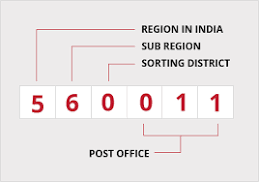

In [32]:
#check unique Zip-Code counts
users['Zip-code'].nunique()

3439

In [33]:
#check number of unique Region+subregion combinations
users['Zip-code'].str.extract(r'(?P<region_and_subregion>\d\d).*').value_counts()

region_and_subregion
55                      415
94                      378
60                      239
02                      221
92                      217
                       ... 
86                        5
82                        5
25                        3
51                        2
69                        1
Length: 100, dtype: int64

In [34]:
#check number of unique regions.
users['Zip-code'].str.extract(r'(?P<region>\d).*').value_counts()

region
9         1468
0          662
1          662
5          659
4          607
2          441
6          430
7          419
3          386
8          306
dtype: int64

**Observations:** 

1. Our intuition tells us that users who belong to the same **subregion** (that is combination of region and subregion codes) are more likely to share some movie preferences compared to those who do not. Similarly, users who belong to the same **region**, regardless of their subregion, are more likley to have shared movie preferences than those who belong to different regions (though the effect may be weaker at regional level than at subregon level). 

2. Subregions are linked to regions and therefore must be interpreted together with their region code. 

3. The number of unique Zip-codes are high (~3.4K). If we hot-encode at Zip-code level, we will generate highly sparse data. Also, using Zip-code data for user similarity may prove to be too granuar. We can instead create on **region** and **subregion** features and one-hot-encode them. 

In [35]:
#create region and subregion features
users['Zip-code'] = users['Zip-code'].str.strip()
users['region'] = users['Zip-code'].str.extract(r'(?P<region>\d).*')
users['subregion'] = users['Zip-code'].str.extract(r'(?P<region>\d\d).*')

In [36]:
#one hot encode region and subregion. Drop zip-code
u = pd.merge(u, pd.get_dummies(users['region'], prefix='r'), left_index=True, right_index=True)
u = pd.merge(u, pd.get_dummies(users['subregion'], prefix='sr'), left_index=True, right_index=True)
u = u.drop(['Zip-code'], axis=1)

In [37]:
u.columns

Index(['UserID', 'Gender', 'age_18-24', 'age_25-34', 'age_35-44', 'age_45-49',
       'age_50-55', 'age_56+', 'age_Under 18', 'K-12 student',
       ...
       'sr_90', 'sr_91', 'sr_92', 'sr_93', 'sr_94', 'sr_95', 'sr_96', 'sr_97',
       'sr_98', 'sr_99'],
      dtype='object', length=140)

### Ratings data

In [38]:
ratings.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [39]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   UserID     1000209 non-null  int64
 1   MovieID    1000209 non-null  int64
 2   Rating     1000209 non-null  int64
 3   Timestamp  1000209 non-null  int64
dtypes: int64(4)
memory usage: 30.5 MB


In [40]:
#convert timestamp (in seconds) to datetime
ratings['Timestamp'] = ratings['Timestamp'].transform(lambda x: pd.Timestamp(x, unit='s'))

<Axes: xlabel='Timestamp', ylabel='count'>

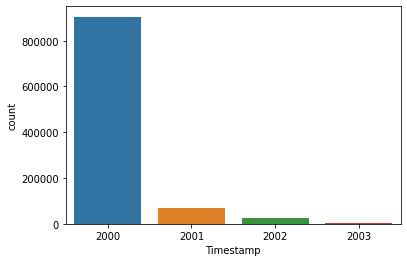

In [41]:
#check year distribution
sns.countplot(x=ratings['Timestamp'].dt.year)

<Axes: xlabel='Timestamp', ylabel='count'>

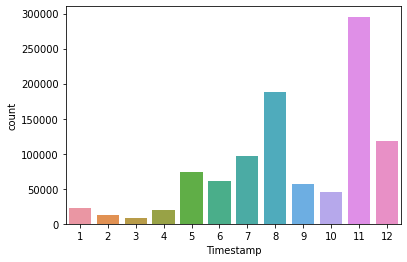

In [42]:
#check month distribution
sns.countplot(x=ratings['Timestamp'].dt.month)

<Axes: xlabel='Timestamp', ylabel='count'>

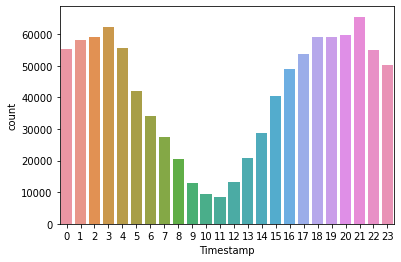

In [43]:
#check hour distribution
sns.countplot(x=ratings['Timestamp'].dt.hour)

**Note:** Hours are cyclic in nature, and therfore regular arithmetic may not provide intended results. For example, *23 hour* is closer to *02 hour* than *17 hour*. Similarly, mean of *23 hour* and *03 hour* should be *01 hour* and not *13 hour*. To avoid such issues, we will use circular encoding. 

For each hour, we extract its sin(or y) and cosine(or x) components and use them as features.

``` python
hour_sin = sin(2*pi*hour / 24)
hour_cos = cos(2*pi*hour / 24)
```

To average multiple hours, we can average their sin and cos components as follow.

``` python
hour_sin_new = (hour_sin1 + hour_sin2) / 2
hour_cos_new = (hour_cos1 + hour_cos2) / 2
```

Finally, we can find hour from its sin and consin components as follow. 

``` python
hour = (arctan(hour_sin / hour_cos) * 12) / pi
```

In [44]:
#extract rating hour value.
ratings['rating_hour'] = ratings['Timestamp'].dt.hour

#extract rating hour sin and cos components
mul = (2*np.pi)/24
ratings['rating_hour_sin'] = np.round(np.sin(mul * ratings['rating_hour']), 2)
ratings['rating_hour_cos'] = np.round(np.cos(mul * ratings['rating_hour']), 2)

In [45]:
# find average rating hour for each user
df_temp = ratings.groupby('UserID')[['rating_hour_sin', 'rating_hour_cos']].mean()
df_temp.rename(columns = {'rating_hour_sin': 'avg_rating_hour_sin', 'rating_hour_cos': 'avg_rating_hour_cos'}, inplace=True)
df_temp['avg_rating_hour'] = (np.arctan2(df_temp['avg_rating_hour_sin'], df_temp['avg_rating_hour_cos']) * 12) / np.pi

mask_neg_hours = df_temp['avg_rating_hour'] < 0
df_temp.loc[mask_neg_hours, 'avg_rating_hour'] = df_temp[mask_neg_hours]['avg_rating_hour'] + 24
df_temp['avg_rating_hour'] = np.round(df_temp['avg_rating_hour']).astype('int') 

<Axes: xlabel='avg_rating_hour', ylabel='count'>

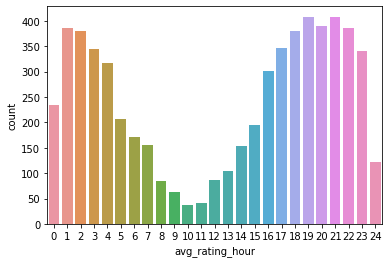

In [46]:
sns.countplot(x=df_temp['avg_rating_hour'])

In [47]:
#add avg_rating_hour, avg_rating_hour_sin, and avg_rating_hour_cos as features to users dataframe
u = pd.merge(u, df_temp.reset_index(), left_on='UserID', right_on='UserID')
u.head()

,UserID,Gender,age_18-24,age_25-34,age_35-44,age_45-49,age_50-55,age_56+,age_Under 18,K-12 student,...,sr_93,sr_94,sr_95,sr_96,sr_97,sr_98,sr_99,avg_rating_hour_sin,avg_rating_hour_cos,avg_rating_hour
0,1,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,-0.441132,0.894528,22
1,2,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,-0.677442,0.734806,21
2,3,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,-0.710000,0.710000,21
3,4,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,-0.870000,0.500000,20
4,5,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.993182,-0.003939,6


In [48]:
#drop timestamp column
ratings.drop('Timestamp', axis=1, inplace=True)

<Axes: xlabel='Rating', ylabel='count'>

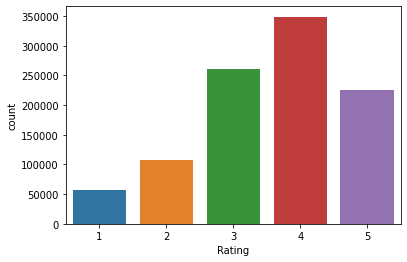

In [49]:
#check ratings feature
sns.countplot(x=ratings['Rating'])

In [50]:
ratings['Rating'].describe()

count    1.000209e+06
mean     3.581564e+00
std      1.117102e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: Rating, dtype: float64

In [51]:
#find 'user_avg_rating' and 'user_rating_cnt'
df_temp = ratings.groupby('UserID').agg({'Rating': ['mean', 'count']})
df_temp.columns = df_temp.columns.droplevel(0)
df_temp = df_temp.rename(columns={'mean':'user_avg_rating', 'count':'user_rating_cnt'}).reset_index()
df_temp.head(3)

,UserID,user_avg_rating,user_rating_cnt
0,1,4.188679,53
1,2,3.713178,129
2,3,3.901961,51


In [52]:
#add user_avg_rating and user_rating_cnt features
u = pd.merge(u, df_temp, left_on='UserID', right_on='UserID')

In [53]:
#find average movie rating as well as total rating count for each movie
df_temp = ratings.groupby('MovieID').agg({'Rating': ['mean', 'count']})
df_temp.columns = df_temp.columns.droplevel(0)
df_temp = df_temp.rename(columns={'mean':'movie_avg_rating', 'count':'movie_rating_cnt'}).reset_index()
df_temp

,MovieID,movie_avg_rating,movie_rating_cnt
0,1,4.146846,2077
1,2,3.201141,701
2,3,3.016736,478
3,4,2.729412,170
4,5,3.006757,296
...,...,...,...
3701,3948,3.635731,862
3702,3949,4.115132,304
3703,3950,3.666667,54
3704,3951,3.900000,40


In [54]:
#add movie_avg_rating and movie_rating_cnt features
m = pd.merge(m, df_temp, left_on='MovieID', right_on='MovieID', how='left').fillna(0)

In [55]:
m.shape

(3883, 23)

In [56]:
str(m.columns.tolist())

'[\'MovieID\', \'Title\', \'release_year\', \'Action\', \'Adventure\', \'Animation\', "Children\'s", \'Comedy\', \'Crime\', \'Documentary\', \'Drama\', \'Fantasy\', \'Film-Noir\', \'Horror\', \'Musical\', \'Mystery\', \'Romance\', \'Sci-Fi\', \'Thriller\', \'War\', \'Western\', \'movie_avg_rating\', \'movie_rating_cnt\']'

In [57]:
str(ratings.columns.tolist())

"['UserID', 'MovieID', 'Rating', 'rating_hour', 'rating_hour_sin', 'rating_hour_cos']"

### Merge all dataframes together

In [58]:
data_agg = pd.merge(m, pd.merge(u, ratings, on='UserID'), left_on='MovieID', right_on='MovieID')
data_agg.head(10)

,MovieID,Title,release_year,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,sr_99,avg_rating_hour_sin,avg_rating_hour_cos,avg_rating_hour,user_avg_rating,user_rating_cnt,Rating,rating_hour,rating_hour_sin,rating_hour_cos
0,1,Toy Story (1995),1995,0,0,1,1,1,0,0,...,0,-0.441132,0.894528,22,4.188679,53,5,23,-0.26,0.97
1,1,Toy Story (1995),1995,0,0,1,1,1,0,0,...,0,0.874225,0.489859,4,3.901408,71,4,4,0.87,0.50
2,1,Toy Story (1995),1995,0,0,1,1,1,0,0,...,0,0.541151,0.833094,2,3.884892,139,4,3,0.71,0.71
3,1,Toy Story (1995),1995,0,0,1,1,1,0,0,...,0,0.260000,0.970000,1,3.735849,106,5,1,0.26,0.97
4,1,Toy Story (1995),1995,0,0,1,1,1,0,0,...,0,0.201571,0.937681,1,4.114713,401,5,1,0.26,0.97
5,1,Toy Story (1995),1995,0,0,1,1,1,0,0,...,0,0.974033,0.212721,5,3.649180,305,4,5,0.97,0.26
6,1,Toy Story (1995),1995,0,0,1,1,1,0,0,...,0,-0.237725,0.691686,23,3.572549,255,5,21,-0.71,0.71
7,1,Toy Story (1995),1995,0,0,1,1,1,0,0,...,1,0.260000,0.970000,1,2.909091,22,3,1,0.26,0.97
8,1,Toy Story (1995),1995,0,0,1,1,1,0,0,...,0,-0.788980,0.260395,19,3.315789,304,4,19,-0.97,0.26
9,1,Toy Story (1995),1995,0,0,1,1,1,0,0,...,0,0.181175,0.468350,1,2.960000,400,3,22,-0.50,0.87


In [59]:
#view all columns of merged data frame.
from IPython.core.display import display, HTML
coldisplay = "<div style='max-width:700px'>"
for i,col in enumerate(data_agg.columns):  
  coldisplay += col + ' ,'
coldisplay += "</div>"
HTML(coldisplay)

### Create the utility matrix (user-item rating matrix)

In [60]:
utility = ratings.pivot(index='UserID', columns='MovieID', values='Rating')
avg_user_rating = utility.mean(axis=1).values.reshape(-1,1) #calculate average user rating
utility = (utility - avg_user_rating) #mean center ratings 
utility = utility.fillna(0) 

### Create item (movie) profile matrix

In [61]:
#create movie profile dataframe. Each row represents a movie vector.
m_profile = m.copy()
m_profile.drop(['Title'], axis=1, inplace=True)
m_profile.set_index('MovieID', inplace=True)
m_profile

,release_year,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,movie_avg_rating,movie_rating_cnt
MovieID,,,,,,,,,,,,,,,,,,,,,
1,1995,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,4.146846,2077.0
2,1995,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,3.201141,701.0
3,1995,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,3.016736,478.0
4,1995,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,2.729412,170.0
5,1995,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,3.006757,296.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3948,2000,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,3.635731,862.0
3949,2000,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,4.115132,304.0
3950,2000,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,3.666667,54.0


<Axes: xlabel='movie_avg_rating', ylabel='Count'>

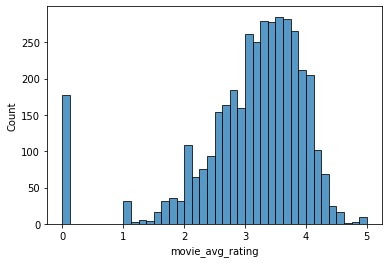

In [62]:
#check distribution of movie_avg_rating
sns.histplot(x=m_profile['movie_avg_rating'])

<Axes: xlabel='movie_rating_cnt', ylabel='Count'>

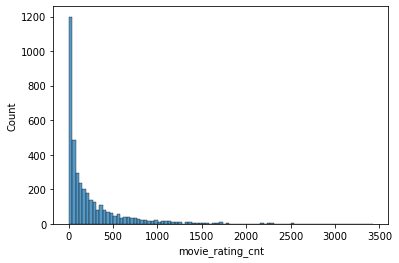

In [63]:
#check distribution of movie_rating_cnt
sns.histplot(x=m_profile['movie_rating_cnt'])

<Axes: xlabel='release_year', ylabel='Count'>

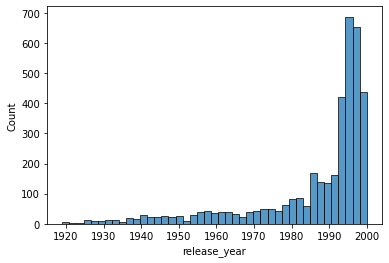

In [64]:
#check distribution of release_year
sns.histplot(x=m_profile['release_year'])

**Note:** 'release_year' has left skewed distribution whrease 'movie_rating_cnt' has right skewed distribution. We will use quantile-transformation to convert them to [0,1] range. 'movie_avg_rating', on the other hand, has relatively symmetric distribution. So we will use StandardScaler.

In [65]:
#apply quantile transform to release_year and movie_rating_cnt
from sklearn.preprocessing import QuantileTransformer
qt = QuantileTransformer(n_quantiles=100, random_state=0)
res = qt.fit_transform(m[['release_year','movie_rating_cnt']].values.reshape(-1,2))
m_profile['release_year'] = res[:,0]
m_profile['movie_rating_cnt'] = res[:,1]

<Axes: xlabel='release_year', ylabel='Count'>

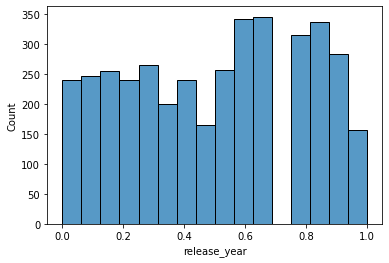

In [66]:
#check distribution again after quantile transform
sns.histplot(x=m_profile['release_year'])

<Axes: xlabel='movie_rating_cnt', ylabel='Count'>

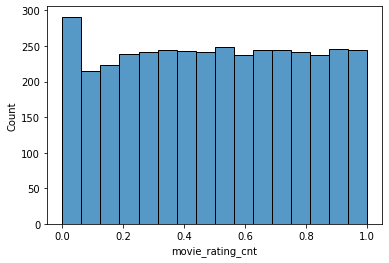

In [67]:
#check distribution again after quantile transform
sns.histplot(x=m_profile['movie_rating_cnt'])

<Axes: xlabel='movie_avg_rating', ylabel='Count'>

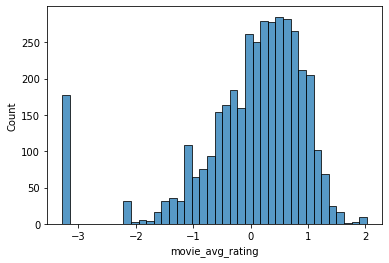

In [68]:
#apply standard scaling to movie_avg_rating
from sklearn.preprocessing import StandardScaler

rating_ss = StandardScaler()
rating_ss.fit(m['movie_avg_rating'].values.reshape(-1,1))
res = rating_ss.transform(m['movie_avg_rating'].values.reshape(-1,1))
m_profile['movie_avg_rating'] = res[:,0]
sns.histplot(x=m_profile['movie_avg_rating'])

In [69]:
# from sklearn.preprocessing import MinMaxScaler

# mm = MinMaxScaler(feature_range=(-1,1))
# res = mm.fit_transform(m_profile[['movie_avg_rating']])
# m_profile['movie_avg_rating'] = res[:,0]
# sns.histplot(x=m_profile['movie_avg_rating'])

In [70]:
#check final movie profile dataframe
m_profile

,release_year,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,movie_avg_rating,movie_rating_cnt
MovieID,,,,,,,,,,,,,,,,,,,,,
1,0.585859,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1.119896,0.991883
2,0.585859,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0.116582,0.898493
3,0.585859,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,-0.079056,0.831031
4,0.585859,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,-0.383883,0.594517
5,0.585859,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,-0.089643,0.725543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3948,1.000000,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0.577645,0.928887
3949,1.000000,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1.086249,0.733220
3950,1.000000,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0.610466,0.370370


### Create user profile matrix (combining user data and ratings)


In [71]:
u.head()

,UserID,Gender,age_18-24,age_25-34,age_35-44,age_45-49,age_50-55,age_56+,age_Under 18,K-12 student,...,sr_95,sr_96,sr_97,sr_98,sr_99,avg_rating_hour_sin,avg_rating_hour_cos,avg_rating_hour,user_avg_rating,user_rating_cnt
0,1,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,-0.441132,0.894528,22,4.188679,53
1,2,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,-0.677442,0.734806,21,3.713178,129
2,3,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,-0.710000,0.710000,21,3.901961,51
3,4,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,-0.870000,0.500000,20,4.190476,21
4,5,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0.993182,-0.003939,6,3.146465,198


<Axes: ylabel='Count'>

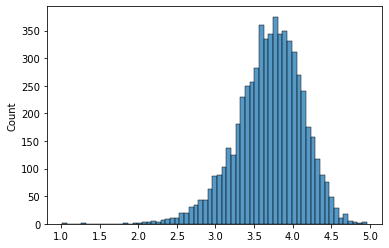

In [72]:
#check distribution of user_rating_cnt
sns.histplot(x=u['user_avg_rating'].values)

<Axes: ylabel='Count'>

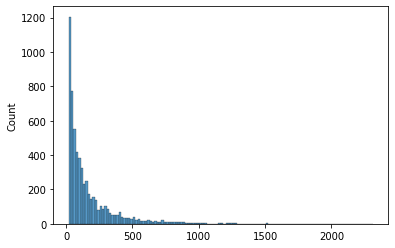

In [73]:
sns.histplot(x=u['user_rating_cnt'].values)

**Observation:** *user_rating_cnt* is positively skewed distribution. We can apply log transform or quantile transform. We will choose quantile transform in this case study. *user_avg_rating* is somewhat symmetric. We can use minmaxscaler to fit it to [-1,1] range.

In [74]:
from sklearn.preprocessing import MinMaxScaler

u2 = u.copy()
u2 = u2.set_index("UserID")
u2.drop('avg_rating_hour', axis=1, inplace=True) #we use sin and cosine components instead

#minmax scale avg_rating
user_mm = MinMaxScaler(feature_range=(-1,1))
u2['user_avg_rating'] = user_mm.fit_transform(u2[['user_avg_rating']])[:,0]

#quantile transform rating_cnt
user_qt = QuantileTransformer(n_quantiles=100, random_state=0)
u2['user_rating_cnt'] = user_qt.fit_transform(u2[['user_rating_cnt']])[:,0]

<Axes: ylabel='Count'>

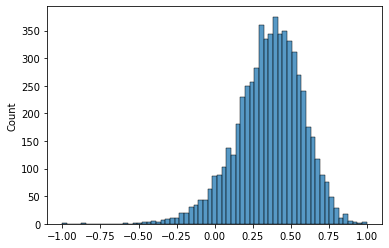

In [75]:
#check transformed avg_rating
sns.histplot(x=u2['user_avg_rating'].values)

<Axes: ylabel='Count'>

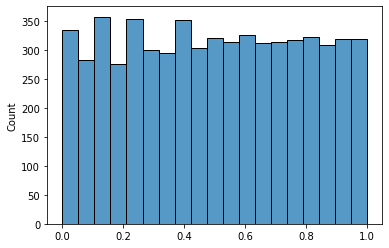

In [76]:
#check transformed rating cnt
sns.histplot(x=u2['user_rating_cnt'].values)

In [77]:
#finally merge user attributes with ratings data to form user profile.
u_profile = u2.merge(utility, left_index=True, right_index=True)
u2 = None
u_profile.head()

,Gender,age_18-24,age_25-34,age_35-44,age_45-49,age_50-55,age_56+,age_Under 18,K-12 student,academic/educator,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0,0,0,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0,0,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1,0,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Item Based Recommendations

### Define Similarity matrix helper functions 

In this section, we first define inner product similarity matrix function using original matrix. We then also define a similar function using sparse matrix (sklearn csr_matrix) and compare their performance. Later, we will similarly define functions for **Pearson correlation based similariy** and **cosine similarity**.

In [78]:
from scipy.sparse import csr_matrix, lil_matrix

#define csr_matrix for item(movies) profile, user profile, and utility matrices
sparse_movies_profile = csr_matrix(m_profile)
sparse_user_profile = csr_matrix(u_profile)
sparse_utility = csr_matrix(utility)

In [79]:
import time

#compute dot product similarity matrix (for non sparse data).
def compute_dot_product_similarity_matrix_nonsparse(df):
  n, m = df.shape
  name = df.index.name
  if type(name) != str:
    name = 'item'

  ids = pd.DataFrame({name: df.index.values}) #item/user/element ids

  ret = ids.merge(ids, how='cross')
  ret['value'] = 0
  t1 = time.time()
  for i in range(n):
    id = df.index[i]
    query = df.iloc[i].values.reshape(1, m ,1)
    candidates = df.values.reshape(n, m ,1)

    grid = np.concatenate((np.repeat(query, repeats=n, axis=0), candidates), axis=2)
    res = grid.prod(axis=2).sum(axis=1)
    ret.iloc[i*n: (i+1)*n, 2] = res

  t2 = time.time()
  ret = ret.pivot(index=f'{name}_x', columns=f'{name}_y', values='value')
  t3 = time.time()

  print(f'time to compute similarity: {t2-t1}, time to pivot: {t3-t2}')

  return ret

#computes dot product similarity on sparse matrix
def compute_dot_product_similarity_matrix_sparse(ids, vectors, name='item'):
  n, m = vectors.shape
  name = 'item'

  ret = pd.DataFrame({name: ids}) #item/user/element ids
  ret = ret.merge(ret, how='cross')
  ret['value'] = 0

  t1 = time.time()
  for i in range(n):
    query = vectors[i].toarray().ravel()   
    res = vectors.dot(query)
    ret.iloc[i*n: (i+1)*n, 2] = res

  t2 = time.time()
  ret = ret.pivot(index=f'{name}_x', columns=f'{name}_y', values='value')
  t3 = time.time()

  print(f'time to compute similarity: {t2-t1}, time to pivot: {t3-t2}')

  return ret

In [80]:
#compute dot product similarity matrix for 200 users (regular matrix)
n = 200
ut_small = utility.iloc[:n].copy() #consider only 200 users
compute_dot_product_similarity_matrix_nonsparse(ut_small)

time to compute similarity: 4.472267150878906, time to pivot: 0.01401972770690918


UserID_y,1,2,3,4,5,6,7,8,9,10,...,191,192,193,194,195,196,197,198,199,200
UserID_x,,,,,,,,,,,,,,,,,,,,,
1,24.113208,1.817464,-1.103589,0.387242,-1.309510,1.543715,0.287888,0.718746,2.554290,-0.367713,...,-0.333333,1.509218,-2.040075,-0.393348,0.666208,-0.404481,-3.051458,2.685468,0.136722,-0.640784
2,1.817464,128.387597,1.861833,-0.912145,-5.840185,-1.508462,2.915979,-0.251910,5.805616,-0.883528,...,1.000000,8.971030,-4.040682,-0.517803,14.047521,-2.802810,3.002114,8.234726,12.694146,0.000000
3,-1.103589,1.861833,48.509804,1.427638,-3.449495,-0.530793,1.651486,-3.053181,-1.265261,0.354310,...,2.163399,4.327171,0.638470,-1.159189,6.369353,1.050245,4.053476,2.194371,5.687738,-0.984917
4,0.387242,-0.912145,1.427638,23.238095,-0.209235,1.073105,-0.622120,1.624529,0.872417,-3.081938,...,0.539683,-6.803810,0.648170,-0.795803,3.392365,0.758929,0.173160,-1.072245,-4.102345,0.000000
5,-1.309510,-5.840185,-3.449495,-0.209235,252.752525,-5.072983,0.611600,7.911998,2.041166,-1.312854,...,3.324916,23.846378,4.260748,-2.486218,4.386659,4.961490,2.877870,23.283428,-2.885233,-4.720474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,-0.404481,-2.802810,1.050245,0.758929,4.961490,-4.607394,0.020161,4.035072,0.066038,3.207918,...,1.583333,1.481429,2.164256,-0.018008,2.436588,19.875000,0.068182,3.843997,2.137593,-0.036058
197,-3.051458,3.002114,4.053476,0.173160,2.877870,-3.165173,0.909091,-1.538914,4.975986,-0.312854,...,1.818182,7.587532,3.313298,0.000000,6.918491,0.068182,23.818182,0.133605,3.764586,0.000000
198,2.685468,8.234726,2.194371,-1.072245,23.283428,-4.543127,4.484041,14.698962,7.185941,17.760342,...,1.584872,81.733132,16.461458,0.486651,53.839727,3.843997,0.133605,379.187335,42.445024,-0.453115


In [81]:
#compute dot product similarity matrix for 200 users (regular matrix)
n = 200
ut_small = utility.iloc[:n].copy() #consider only 200 users
compute_dot_product_similarity_matrix_sparse(ut_small.index.values, csr_matrix(ut_small))

time to compute similarity: 0.10673189163208008, time to pivot: 0.014732837677001953


item_y,1,2,3,4,5,6,7,8,9,10,...,191,192,193,194,195,196,197,198,199,200
item_x,,,,,,,,,,,,,,,,,,,,,
1,24.113208,1.817464,-1.103589,0.387242,-1.309510,1.543715,0.287888,0.718746,2.554290,-0.367713,...,-0.333333,1.509218,-2.040075,-0.393348,0.666208,-0.404481,-3.051458,2.685468,0.136722,-0.640784
2,1.817464,128.387597,1.861833,-0.912145,-5.840185,-1.508462,2.915979,-0.251910,5.805616,-0.883528,...,1.000000,8.971030,-4.040682,-0.517803,14.047521,-2.802810,3.002114,8.234726,12.694146,0.000000
3,-1.103589,1.861833,48.509804,1.427638,-3.449495,-0.530793,1.651486,-3.053181,-1.265261,0.354310,...,2.163399,4.327171,0.638470,-1.159189,6.369353,1.050245,4.053476,2.194371,5.687738,-0.984917
4,0.387242,-0.912145,1.427638,23.238095,-0.209235,1.073105,-0.622120,1.624529,0.872417,-3.081938,...,0.539683,-6.803810,0.648170,-0.795803,3.392365,0.758929,0.173160,-1.072245,-4.102345,0.000000
5,-1.309510,-5.840185,-3.449495,-0.209235,252.752525,-5.072983,0.611600,7.911998,2.041166,-1.312854,...,3.324916,23.846378,4.260748,-2.486218,4.386659,4.961490,2.877870,23.283428,-2.885233,-4.720474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,-0.404481,-2.802810,1.050245,0.758929,4.961490,-4.607394,0.020161,4.035072,0.066038,3.207918,...,1.583333,1.481429,2.164256,-0.018008,2.436588,19.875000,0.068182,3.843997,2.137593,-0.036058
197,-3.051458,3.002114,4.053476,0.173160,2.877870,-3.165173,0.909091,-1.538914,4.975986,-0.312854,...,1.818182,7.587532,3.313298,0.000000,6.918491,0.068182,23.818182,0.133605,3.764586,0.000000
198,2.685468,8.234726,2.194371,-1.072245,23.283428,-4.543127,4.484041,14.698962,7.185941,17.760342,...,1.584872,81.733132,16.461458,0.486651,53.839727,3.843997,0.133605,379.187335,42.445024,-0.453115


**Observations:** We can observe that working with csr_matrix is much faster compared to regular matrices. We will next define helper functions for computing similarity matrices using pearson correlation and cosine similarity measures. We will be using csr_matrix for performance reasons. 

In [82]:
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity

#computes Pearson correlation pairwise similarity matrix (input is sparse matrix)
def compute_pearson_similarity_matrix_sparse(ids, vectors, rounding_scale=3):
  n, m = vectors.shape
  name = 'item'

  ret = pd.DataFrame({name: ids}) #item/user/element ids
  ret = ret.merge(ret, how='cross')
  ret['value'] = 0
  
  t1 = time.time()
  corr_mat = lil_matrix((n, n))
  for i in range(n):
    for j in range(i+1, n):
        item1, item2 = vectors[i].toarray().ravel(), vectors[j].toarray().ravel()
        corr, _ = pearsonr(item1, item2)
        corr_mat[i, j] = corr_mat[j, i] = np.round(corr, rounding_scale)
  #corr_mat = corr_mat.tocsr()
  #return corr_mat
  t2 = time.time()
  print('Time taken: ', t2-t1)
  return pd.DataFrame(corr_mat.toarray(), index=ids, columns=ids)
  
#computes pairwise cosine similarity matrix (input is sparse matrix)
def compute_cosine_similarity_matrix_sparse(ids, vectors, rounding_scale=3):
  t1 = time.time()
  res = np.round(cosine_similarity(vectors), rounding_scale)
  t2 = time.time()
  print('Time taken: ', t2-t1)
  return pd.DataFrame(res, index=ids, columns=ids)


### Item based similarity using (modified) Pearson correlation

**Approach:** Find items(movies) which are similar to the given item(movie) using Pearson correlation as similarity measure. For each candidate movie and the given query movie, we can compute correlation in two basic ways. 

1. Compute correlation using all features. However, with this approach, becuase of sparsity of vectors, computed correlation score may not be accurate. 

2. Compute correlation using only common non-zero features of the query and candidate vectors. This should work well as long as there are sufficient number of common non-zero features between two vectors. If, however, there are very small subset of common features (E.g. two movies belonging to entirely different set of genres, but released in the same year and with same ratings will be considered highly similar)

One implementation approach is to combine both the approaches by taking minimum of the above two correlation scores as the final correlation value. 

```python
corr = pearsonr(query, candidate)

if specialcorr == True:
  let cf = set of common non-zero features of both query and candidate.
  corr_common_feat =  pearsonr(query[cf], candidate[cf])
  corr = min(corr, corr_common_feat)

```

Higher positive correlation implies more similarity, higher negative correlation implies more dissimilarity, and zero correlation implies unrelated movies. For recommendations, we return movies with highest positive correlation values.

In [83]:
#find similar movies based on modified pearson correlation.
def find_similar_movies_pearson(query_obj = None, query_id = None, topN=0, corrtype='both', rounding_scale=3):
  n, m = m_profile.shape
  name = 'item'

  ret = pd.DataFrame({name: m_profile.index.values}) #item/user/element ids
  ret['corr'] = 0
  
  if query_id is not None:
    query = m_profile.loc[query_id]
  elif query_obj is not None: 
    query = query_obj
  else:
    raise "must supply one of query_obj or query_id"

  query_mask = query != 0 #features where query movie has non-zero entries

  t1 = time.time()

  #compute correlation
  for i in range(n):
    
    candidate = m_profile.iloc[i]
    #regular correlation
    corr1, _ = pearsonr(query, candidate)

    if corrtype == 'both' or corrtype == 'subset':  #also compute correlation based on common features. Take min of both correlations as the final correlation.
      candidate_mask = candidate != 0 #feature where candidate movie has non-zero entries
      and_mask = query_mask & candidate_mask #features where both query and candidate movie have non-zero entries
      
      if(and_mask.sum() > 2):
        #compute pearson correlation on the subset of features
        corr2, _ = pearsonr(query[and_mask], candidate[and_mask])
      else: #subset too small. default to standard
        corr2 = np.NAN
        
    if(corrtype == 'both'):
      corr = min([corr1, corr2])
    elif(corrtype == 'subset' and ~np.isnan(corr2)):
      corr = corr2
    else: #standard correlation using all features
      corr = corr1
    
    ret.iloc[i,1] = corr

  ret['corr'] = np.round(ret['corr'], rounding_scale)  
  
  #remove query object from result if necessary
  if query_id is not None:
    ret = ret[ret[name] != query_id].copy()
  
  #sort by correlation in descending
  ret = ret.sort_values(by='corr', ascending=False)

  #return topN if asked
  if(topN > 0):
    ret = ret[:topN]
  
  t2 = time.time()
  print('Time taken: ', t2-t1)
  return ret


**Example 1:** Find top 5 movies similar to movie id 1.

In [84]:
qid = 1
res = find_similar_movies_pearson(query_id=qid, topN=5)
res

Time taken:  13.690950632095337


,item,corr
1205,1223,0.865
1132,1148,0.862
3360,3429,0.858
2070,2139,0.855
3327,3396,0.854


In [85]:
#show query movies and movies similar movies it
m_profile.loc[[qid] + res['item'].values.tolist()]

,release_year,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,movie_avg_rating,movie_rating_cnt
MovieID,,,,,,,,,,,,,,,,,,,,,
1,0.585859,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1.119896,0.991883
1223,0.419192,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1.347649,0.828580
1148,0.454545,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1.502982,0.931714
3429,0.378788,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1.320324,0.708028
2139,0.242424,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.805973,0.775741
3396,0.212121,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0.811526,0.907625


**Example 2:** Find top 10 movies similar to a movie with the characteristics defined as follow. 

- release_year : 1995
- genres : Crime, Thriller 
- rating : 4

In [86]:
release_year = qt.transform([[1995, 0]])[0][0]
rating = rating_ss.transform([[4]])[0][0]

qobj = pd.Series([release_year, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, rating, 0])
res = find_similar_movies_pearson(query_obj=qobj, topN=5)
res

Time taken:  12.235384941101074


,item,corr
653,659,0.930
2883,2952,0.914
46,47,0.861
49,50,0.860
2848,2917,0.855


In [87]:
#show similar movies
m_profile.loc[res['item'].values.tolist()]

,release_year,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,movie_avg_rating,movie_rating_cnt
MovieID,,,,,,,,,,,,,,,,,,,,,
659,0.106061,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0.667048,0.247475
2952,0.676768,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0.696023,0.614966
47,0.585859,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,1.077007,0.961040
50,0.585859,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,1.512710,0.990117
2917,0.232323,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0.997784,0.842239


### item-item cosine similarity matrix

In [88]:
movies_sm = compute_cosine_similarity_matrix_sparse(m_profile.index.values, sparse_movies_profile)
movies_sm

Time taken:  0.4716513156890869


,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
1,1.000,0.491,0.505,0.377,0.606,0.422,0.607,0.443,0.098,0.362,...,0.570,0.120,0.161,0.014,0.337,0.747,0.555,0.437,0.467,0.454
2,0.491,1.000,0.304,0.242,0.352,0.284,0.310,0.835,0.266,0.520,...,0.330,0.146,0.497,0.201,0.203,0.408,0.349,0.306,0.282,0.332
3,0.505,0.304,1.000,0.635,0.818,0.273,0.972,0.250,0.336,0.294,...,0.762,0.509,0.215,0.271,0.186,0.742,0.330,0.306,0.265,0.333
4,0.377,0.242,0.635,1.000,0.783,0.155,0.570,0.231,0.359,0.201,...,0.748,0.901,0.321,0.586,0.083,0.636,0.494,0.588,0.508,0.516
5,0.606,0.352,0.818,0.783,1.000,0.312,0.787,0.298,0.402,0.338,...,0.945,0.646,0.269,0.331,0.209,0.901,0.386,0.368,0.319,0.391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3948,0.747,0.408,0.742,0.636,0.901,0.489,0.804,0.324,0.323,0.459,...,0.906,0.426,0.068,0.235,0.360,1.000,0.670,0.599,0.594,0.591
3949,0.555,0.349,0.330,0.494,0.386,0.510,0.456,0.261,0.171,0.440,...,0.453,0.252,-0.119,0.323,0.394,0.670,1.000,0.961,0.974,0.858
3950,0.437,0.306,0.306,0.588,0.368,0.411,0.391,0.274,0.229,0.366,...,0.487,0.443,0.020,0.463,0.299,0.599,0.961,1.000,0.990,0.848
3951,0.467,0.282,0.265,0.508,0.319,0.427,0.380,0.241,0.152,0.363,...,0.443,0.339,-0.080,0.370,0.322,0.594,0.974,0.990,1.000,0.837


### user-user cosine similarity matrix

In [89]:
users_sm = compute_cosine_similarity_matrix_sparse(users['UserID'].values, sparse_user_profile, rounding_scale=1)
users_sm

Time taken:  4.935536623001099


,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
1,1.0,0.1,0.0,0.1,-0.0,0.1,0.0,0.0,0.1,0.0,...,0.0,0.0,0.1,0.0,0.1,-0.0,0.0,0.0,0.0,0.0
2,0.1,1.0,0.0,0.0,-0.0,-0.0,0.1,0.0,0.1,0.0,...,0.0,0.0,0.1,0.0,0.1,0.1,0.1,0.0,0.0,0.0
3,0.0,0.0,1.0,0.1,0.0,0.0,0.1,-0.0,0.0,0.0,...,-0.0,0.1,0.0,0.1,0.0,0.0,0.0,0.1,0.1,-0.0
4,0.1,0.0,0.1,1.0,-0.0,0.0,0.1,0.0,0.0,-0.0,...,-0.0,0.1,0.0,0.1,-0.0,0.0,0.0,-0.0,0.1,0.0
5,-0.0,-0.0,0.0,-0.0,1.0,-0.0,0.0,0.1,0.0,-0.0,...,0.0,0.0,0.0,0.0,0.1,0.1,-0.0,-0.0,0.0,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,-0.0,0.1,0.0,0.0,0.1,-0.0,0.0,0.1,0.0,0.0,...,0.0,0.0,0.1,0.1,0.1,1.0,0.0,-0.0,0.0,0.1
6037,0.0,0.1,0.0,0.0,-0.0,-0.0,0.0,0.0,0.1,0.0,...,0.0,0.1,0.0,0.0,0.0,0.0,1.0,0.0,0.1,0.1
6038,0.0,0.0,0.1,-0.0,-0.0,-0.0,0.1,0.0,0.1,0.1,...,-0.0,0.0,0.1,0.0,0.0,-0.0,0.0,1.0,0.1,-0.0
6039,0.0,0.0,0.1,0.1,0.0,-0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.1,0.0,0.0,0.1,0.1,1.0,0.1


### item based similarity using cosine similarity

In [90]:
#find similar movies based on cosine similarity among movies.
def find_similar_movies_cosine(query_obj = None, query_id = None, topN=0, rounding_scale=3):
  n, m = m_profile.shape
  name = 'item'

  ret = pd.DataFrame({name: m_profile.index.values}) #item/user/element ids
  ret['similarity'] = 0
  
  if query_id is not None:
    query = m_profile.loc[query_id]
  elif query_obj is not None: 
    query = query_obj
  else:
    raise "must supply one of query_obj or query_id"

  t1 = time.time()

  #compute cosine similarity
  ret['similarity'] = np.round(cosine_similarity(m_profile.values, query.values.reshape(1,-1)), rounding_scale)
  
  #remove query object from result if necessary
  if query_id is not None:
    ret = ret[ret[name] != query_id].copy()
  
  #sort by similarity in descending
  ret = ret.sort_values(by='similarity', ascending=False)

  #return topN if asked
  if(topN > 0):
    ret = ret[:topN]
  
  t2 = time.time()
  print('Time taken: ', t2-t1)
  return ret

**Example 1:** Find top 5 movies similar to movie id 1.

In [91]:
qid = 1
res = find_similar_movies_cosine(query_id=qid, topN=5)
res

Time taken:  0.013625860214233398


,item,similarity
3045,3114,0.991
2286,2355,0.985
3682,3751,0.978
2072,2141,0.942
1205,1223,0.896


In [92]:
#show query movies and movies similar movies it
m_profile.loc[[qid] + res['item'].values.tolist()]

,release_year,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,movie_avg_rating,movie_rating_cnt
MovieID,,,,,,,,,,,,,,,,,,,,,
1,0.585859,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1.119896,0.991883
3114,0.924242,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1.196368,0.984857
2355,0.843434,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0.809608,0.988535
3751,1.000000,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0.836379,0.974501
2141,0.308081,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0.357492,0.797432
1223,0.419192,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1.347649,0.828580


**Example 2:** Find top 10 movies similar to a movie with the characteristics defined as follow. 

- release_year : 1995
- genres : Crime, Thriller 
- rating : 4


In [93]:
release_year = qt.transform([[1995, 0]])[0][0]
rating = rating_ss.transform([[4]])[0][0]

qobj = pd.Series([release_year, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, rating, 0])
res = find_similar_movies_cosine(query_obj=qobj, topN=5)
res


Time taken:  0.006042957305908203


,item,similarity
653,659,0.942
2883,2952,0.931
46,47,0.888
49,50,0.887
2848,2917,0.883


In [94]:
#show similar movies
m_profile.loc[res['item'].values.tolist()]

,release_year,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,movie_avg_rating,movie_rating_cnt
MovieID,,,,,,,,,,,,,,,,,,,,,
659,0.106061,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0.667048,0.247475
2952,0.676768,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0.696023,0.614966
47,0.585859,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,1.077007,0.961040
50,0.585859,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,1.512710,0.990117
2917,0.232323,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0.997784,0.842239


### item based cosine similarity using sklearn NearestNeighbors

In [ ]:
from sklearn.neighbors import NearestNeighbors


def find_similar_movies_cosine_knn(query_obj = None, query_id = None, k=5, rounding_scale=3):
  n, m = m_profile.shape
  name = 'item'

  ret = pd.DataFrame(columns={name: [], 'cosine_distance': []}) #item/user/element ids
  ret['cosine_distance'] = 0
  
  if query_id is not None:
    query = m_profile.loc[query_id].values
  elif query_obj is not None: 
    query = query_obj
  else:
    raise "must supply one of query_obj or query_id"

  t1 = time.time()

  # Create NearestNeighbors model
  nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto', metric='cosine').fit(m_profile.values)

  # Find the nearest neighbors
  distances, indices = nbrs.kneighbors(query.reshape(1,-1))
  
  ret[name] = indices.flatten()
  ret['cosine_distance'] = np.round(distances.flatten(), rounding_scale)
  
  #remove query object from result if necessary
  if query_id is not None:
    ret = ret[ret[name] != query_id].copy()
  
  if(ret.shape[0] > k):
    ret = ret[1:k+1]

  #sort by similarity in descending
  ret = ret.sort_values(by='cosine_distance', ascending=True)

  t2 = time.time()
  print('Time taken: ', t2-t1)
  return ret


**Example 1:** Find top 5 movies similar to movie id 1.

In [154]:
qid = 1
res = find_similar_movies_cosine_knn(query_id=qid, k=5)
res


Time taken:  0.025053024291992188


,item,cosine_distance
1,3045,0.009
2,2286,0.015
3,3682,0.022
4,2072,0.058
5,584,0.104


In [155]:
#show query movies and movies similar movies it
m_profile.loc[[qid] + res['item'].values.tolist()]

,release_year,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,movie_avg_rating,movie_rating_cnt
MovieID,,,,,,,,,,,,,,,,,,,,,
1,0.585859,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1.119896,0.991883
3045,0.419192,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0.002087,0.513709
2286,0.222222,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,-0.614933,0.328283
3682,0.171717,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0.635726,0.644444
2072,0.363636,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,-0.191349,0.732182
584,0.454545,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0.964104,0.060606


## Collaborative filtering - Matrix factorization

In [95]:
#create rating matrix. We also add those movies which do not have any ratings. This is to ensure that we get all movies when we create embeddings.
df_temp = pd.merge(movies[['MovieID']], ratings, how='left')
df_temp['Rating'] = df_temp['Rating'].fillna(0).astype('int')
df_temp['UserID'] = df_temp['UserID'].fillna(users['UserID'][0]).astype('int') 

rm = df_temp.pivot(index='UserID', columns='MovieID', values='Rating').fillna(0)

#### Train/test strategy

For each user, we set aside roughly 20% ratings for test and the remaining for training. 

In [96]:
#Helper function to create train and test ratings matrices.
def create_train_test_matrices(rm, test_frac=0.2):
  n, m =  rm.shape
  
  t1 = time.time()

  #create train and test matrices.
  train_rm = rm.copy()
  test_rm = rm.copy()

  #holds indices of movies starting from 1 (so that we can use 0 as the absence of rating)
  m_indices = np.array([i for i in range(1, m+1)])

  for i in range(n): #for each user
    user_row = rm.iloc[i].values
    is_rating_present = (user_row > 0).astype('int')
    
    # find indices where ratings are present
    user_rating_indices = is_rating_present * m_indices
    user_rating_indices = pd.Series(user_rating_indices[user_rating_indices > 0 ] - 1)
    
    #compute test size
    test_size = int(round(user_rating_indices.shape[0] * test_frac))

    #randomly choose indices as test
    test_indices = np.random.choice(a=user_rating_indices, size=test_size, replace=False)
    train_indices = user_rating_indices[~user_rating_indices.isin(test_indices)]

    #create train and test mask
    test_mask, train_mask = np.zeros(m), np.zeros(m)
    test_mask[test_indices] = 1
    train_mask[train_indices] = 1

    train_rm.iloc[i] = train_rm.iloc[i] * train_mask
    test_rm.iloc[i] = test_rm.iloc[i] * test_mask

  t2 = time.time()
  print('time taken to create train test matrices: ', t2-t1)

  return train_rm, test_rm

In [97]:
#create train test rating matrices (with 80:20 proportion).
train_rm, test_rm = create_train_test_matrices(rm, test_frac=0.2)

time taken to create train test matrices:  7.1581761837005615


In [98]:
#check number of ratings in train matrix
train_ratings_cnt = (~train_rm[train_rm > 0].isna()).sum(axis=1).sum()
train_ratings_cnt

800193

In [99]:
#check number of ratings in test matrix
test_ratings_cnt = (~test_rm[test_rm > 0].isna()).sum(axis=1).sum()
test_ratings_cnt

200016

In [100]:
#confirm that total number ratings =  number of train ratings +  number of test ratings
total_ratings_cnt = (~rm[rm > 0].isna()).sum(axis=1).sum()
total_ratings_cnt == (train_ratings_cnt + test_ratings_cnt)

True

#### Matrix factorization using cmfrec

In [101]:
from cmfrec import CMF
from sklearn.metrics import mean_squared_error as mse, mean_absolute_percentage_error as mape

In [102]:
#get long form raw rm from wide form rm
def get_rm_raw_from_rm(rm, keep_items_with_no_ratings=True):
  
  rm = rm.copy()

  if keep_items_with_no_ratings == True:
    #find all items without any ratings. 
    #For these items, add dummy rating of 6 against first user. 
    #We do so, because when we remove all zero ratings after converting to long form, 
    #we want to preserve atleast one rating for these items. 
    #before returning, we convert these dummy ratings to zero.
  
    items_with_no_ratings = rm.loc[:, rm.sum(axis=0) == 0].columns.values  
    rm.loc[rm.index[0], items_with_no_ratings] = 6
  
  #unstack to get long form
  rm_raw = rm.unstack()
  rm_raw = rm_raw[rm_raw > 0] #take only positive ratings
  rm_raw = rm_raw.reset_index()[['UserID', 'MovieID', 0]]
  rm_raw.columns = ['UserId', 'ItemId', 'Rating']
  rm_raw[rm_raw == 6] = 0 #assign zero rating wherever we had set dummy rating.
  return rm_raw

#compute and return rmse and mape 
def compute_error_metrics(actual, predicted):
  rmse_err = mse(actual, predicted)**0.5
  mape_err = mape(actual, predicted)
  return rmse_err, mape_err

##### Prepare train and test data in long format

In [103]:
#prepare raw rm from train data (preserve all items without any rating)
train_rm_raw = get_rm_raw_from_rm(train_rm, keep_items_with_no_ratings=True)
train_rm_raw.head()

,UserId,ItemId,Rating
0,1,1,5.0
1,0,1,4.0
2,8,1,4.0
3,9,1,5.0
4,10,1,5.0


In [104]:
#prepare raw rm from test data (don't preserve items without ratings)
test_rm_raw = get_rm_raw_from_rm(test_rm, keep_items_with_no_ratings=False)
test_rm_raw.head()

,UserId,ItemId,Rating
0,28,1,3.0
1,73,1,3.0
2,75,1,5.0
3,76,1,5.0
4,78,1,4.0


##### Create model on train data

In [105]:
#create model and fit on training data
model = CMF(method="als", k=4, lambda_=0.1, user_bias=False, item_bias=False, verbose=False)
model.fit(train_rm_raw)

Collective matrix factorization model
(explicit-feedback variant)


In [106]:
model.A_.shape, model.B_.shape

((6040, 4), (3883, 4))

##### Test performance on train data

In [107]:
#compute performance on train data
train_rm__ = np.dot(model.A_, model.B_.T) + model.glob_mean_
train_actual = train_rm.values[train_rm > 0]
train_pred = train_rm__[train_rm > 0]
train_pred_tr = np.round(np.clip(train_pred, 1, 5)).astype('int') 

train_rmse_err, train_mape_err = compute_error_metrics(train_actual, train_pred_tr)
print(train_rmse_err, train_mape_err)

1.2040033339668108 0.3367440105074651


##### Test performance on test data

In [108]:
#compute performance on test data
test_actual = test_rm_raw['Rating']
test_pred = model.predict(test_rm_raw['UserId'], test_rm_raw['ItemId'])
test_pred_tr = np.round(np.clip(test_pred, 1, 5)).astype('int')

test_rmse_err, test_mape_err = compute_error_metrics(test_actual, test_pred_tr)
print(test_rmse_err, test_mape_err)

0.9205173609568992 0.24883384329253652


##### plot distribution of train and test residuals

<Axes: ylabel='Count'>

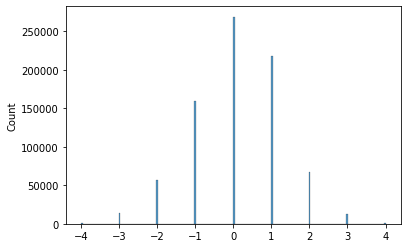

In [109]:
# plot train errors
sns.histplot(train_actual - train_pred_tr)

<Axes: xlabel='Rating', ylabel='Count'>

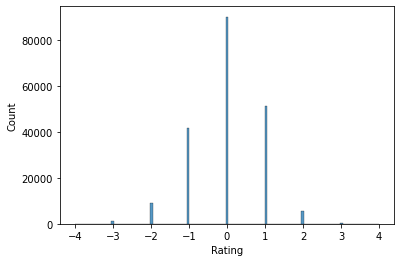

In [110]:
# plot test errors
sns.histplot(test_actual - test_pred_tr)

### Embeddings for item-item and user-user similarity

In this section, we find item-item and user-user similarity using the embeddings created by matrix factorization. We then compare the resultant similarity matrices against the corresponding similarity matrices computed from original data.

In [111]:
import matplotlib.pyplot as plt

# helper function to visualize similarity matrix
def visualize_similarity_mat(sm, sm2, figsize=None, cmap='crest', center=None, ax=None, title1="", title2=""):
  single = sm2 is None
  if figsize is None:
    figsize = (10, 8) if single else (16, 6)
  
  fig, axes = None, ax
  if axes is None:
    r = 1 
    c = 1 if single else 2
    fig, axes = plt.subplots(r, c, figsize=figsize)
    
  if np.array(axes).ndim == 0:
    axes = np.array(axes).reshape(1)

  sns.heatmap(sm, cmap=cmap, center=center, ax=axes[0])
  axes[0].set_title(title1)

  if not single:
    sns.heatmap(sm2, cmap=cmap, center=center, ax=axes[1])
    axes[1].set_title(title2)
    
  plt.show()

def plot_similarity_dist(sm1, sm2):
  fig, axes = plt.subplots(1, 2, figsize=(16,6))
  sns.histplot(x=sm1.values.flatten(), ax=axes[0])
  sns.histplot(x=sm2.values.flatten(), ax=axes[1])
  plt.show()

def get_similarity_matrix_subset(sm, ids=None, n=None):
  if ids is None:
    ids = np.random.choice(a=sm.index.values, size=n, replace=False)

  return sm.loc[ids, ids], ids

#### Create user and movie embeddings for d=4 and d=2

In [112]:
#creating user and item embeddings (d=4)
rm_raw = get_rm_raw_from_rm(rm)
model_d4 = CMF(method="als", k=4, lambda_=0.1, user_bias=False, item_bias=False, verbose=False)
model_d4.fit(rm_raw)

user_embedding_d4 = csr_matrix(model_d4.A_)
item_embedding_d4 = csr_matrix(model_d4.B_)

In [113]:
#creating user and item embeddings (d=2)
rm_raw = get_rm_raw_from_rm(rm)
model_d2 = CMF(method="als", k=2, lambda_=0.1, user_bias=False, item_bias=False, verbose=False)
model_d2.fit(rm_raw)

user_embedding_d2 = csr_matrix(model_d2.A_)
item_embedding_d2 = csr_matrix(model_d2.B_)

#### create similarity matrices using *Raw* data

We create the following similarity matrices

1. item-item cosine similarity
2. user-user cosine similarity


Time taken:  0.5298516750335693


<Axes: ylabel='Count'>

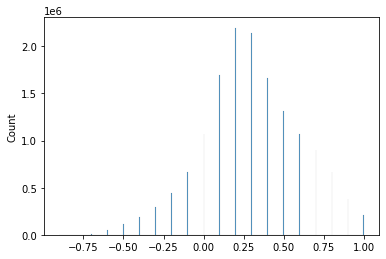

In [114]:
#item item cosine similarity matrix using raw data
item_item_raw_cosine = compute_cosine_similarity_matrix_sparse(movies['MovieID'], sparse_movies_profile, rounding_scale=1)
sns.histplot(x=item_item_raw_cosine.values.flatten())

Time taken:  7.935024738311768


<Axes: ylabel='Count'>

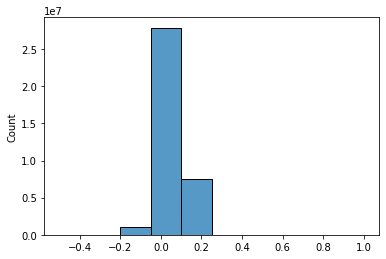

In [157]:
#user user cosine similarity matrix using raw data
user_user_raw_cosine = compute_cosine_similarity_matrix_sparse(users['UserID'], sparse_utility, rounding_scale=1)
sns.histplot(x=user_user_raw_cosine.values.flatten(), bins=10)

#### create similarity matrices using *embeddings*

We create the following similarity matrices.

1. item-item cosine similarity for d=4
2. user-user cosine similarity for d=4
1. item-item cosine similarity for d=2
2. user-user cosine similarity for d=2

Time taken:  0.51774001121521


<Axes: ylabel='Count'>

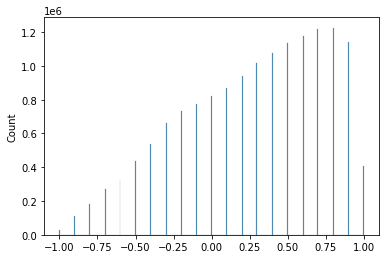

In [116]:
#item item cosine similarity matrix with d4 embedding
item_item_d4_cosine = compute_cosine_similarity_matrix_sparse(movies['MovieID'], item_embedding_d4, rounding_scale=1)
sns.histplot(x=item_item_d4_cosine.values.flatten())

Time taken:  0.32555556297302246


<Axes: ylabel='Count'>

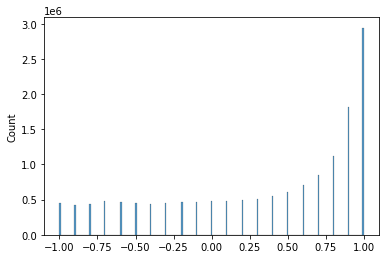

In [117]:
#item item cosine similarity matrix with d2 embedding
item_item_d2_cosine = compute_cosine_similarity_matrix_sparse(movies['MovieID'], item_embedding_d2, rounding_scale=1)
sns.histplot(x=item_item_d2_cosine.values.flatten())

Time taken:  0.9482672214508057


<Axes: ylabel='Count'>

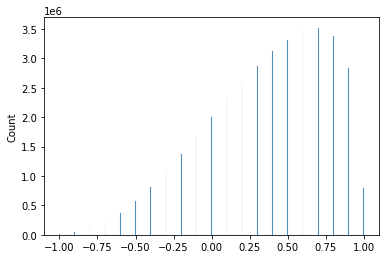

In [118]:
#user user cosine similarity matrix with d4 embedding
user_user_d4_cosine = compute_cosine_similarity_matrix_sparse(users['UserID'], user_embedding_d4, rounding_scale=1)
sns.histplot(x=user_user_d4_cosine.values.flatten())

Time taken:  0.770803689956665


<Axes: ylabel='Count'>

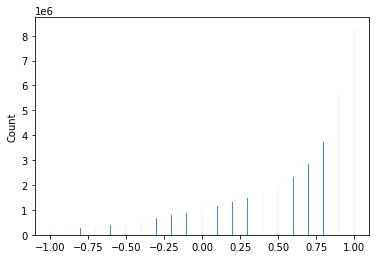

In [119]:
#user user cosine similarity matrix with d2 embedding
user_user_d2_cosine = compute_cosine_similarity_matrix_sparse(users['UserID'], user_embedding_d2, rounding_scale=1)
sns.histplot(x=user_user_d2_cosine.values.flatten())

#### Visualize and compare similarity matrices for raw data and embeddings

In [120]:
sim_matrices = [
  {
      "sm1": [item_item_raw_cosine, 'item-item raw'],
      "sm2": [item_item_d4_cosine, 'item-item embedding(d=4)']
  },
  {
      "sm1": [item_item_raw_cosine, 'item-item raw'],
      "sm2": [item_item_d2_cosine, 'item-item embedding(d=2)']
  },
  {
      "sm1": [user_user_raw_cosine, 'user-user raw'],
      "sm2": [user_user_d4_cosine, 'user-user embedding(d=4)']
  },
  {
      "sm1": [user_user_raw_cosine, 'user-user raw'],
      "sm2": [user_user_d2_cosine, 'user-user embedding(d=2)']
  }
]

<IPython.core.display.Javascript object>

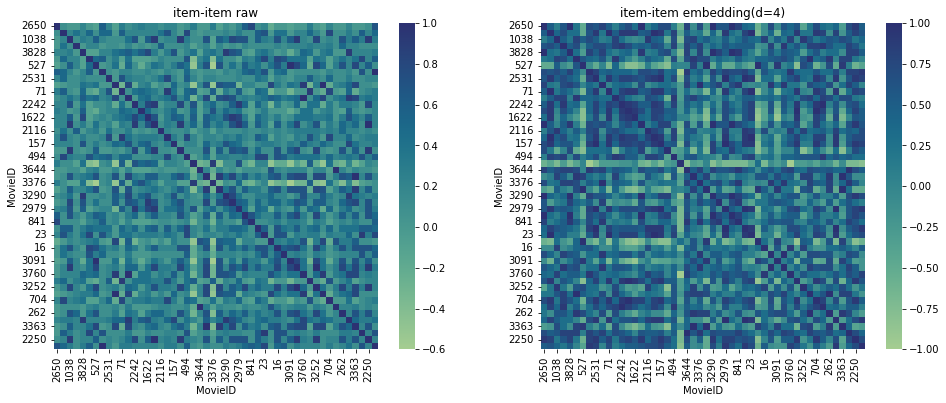


RMSE between item-item raw and item-item embedding(d=4): 0.45496289701600207
Distribution of item-item raw - item-item embedding(d=4)


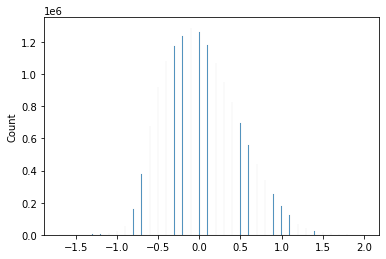

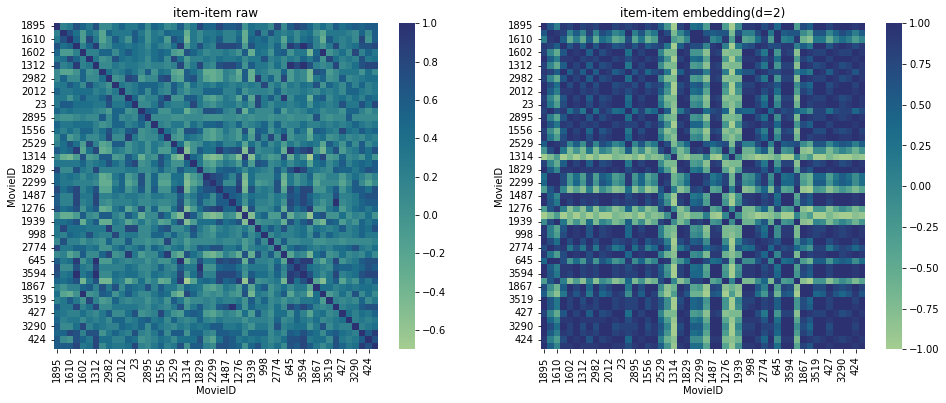


RMSE between item-item raw and item-item embedding(d=2): 0.5915489818934705
Distribution of item-item raw - item-item embedding(d=2)


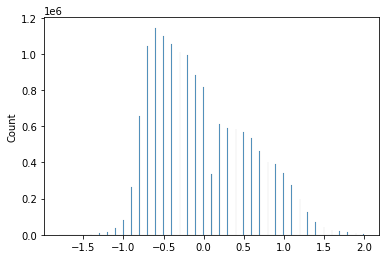

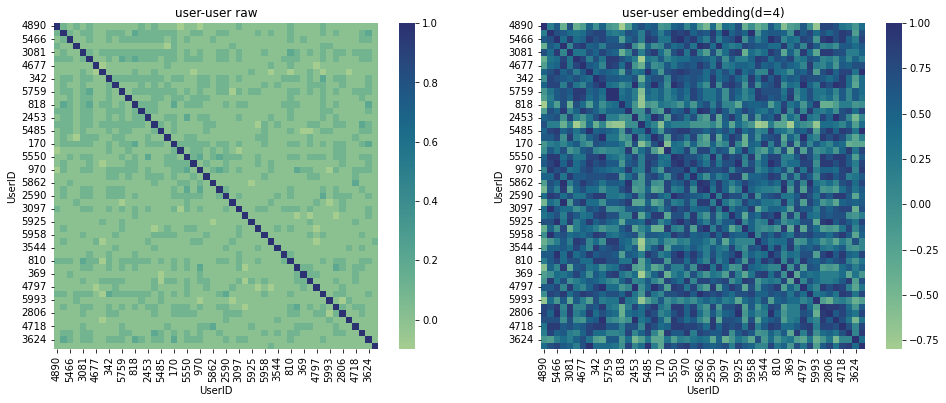


RMSE between user-user raw and user-user embedding(d=4): 0.5321302795059191
Distribution of user-user raw - user-user embedding(d=4)


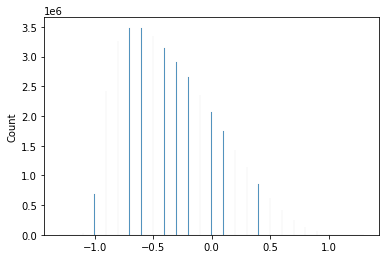

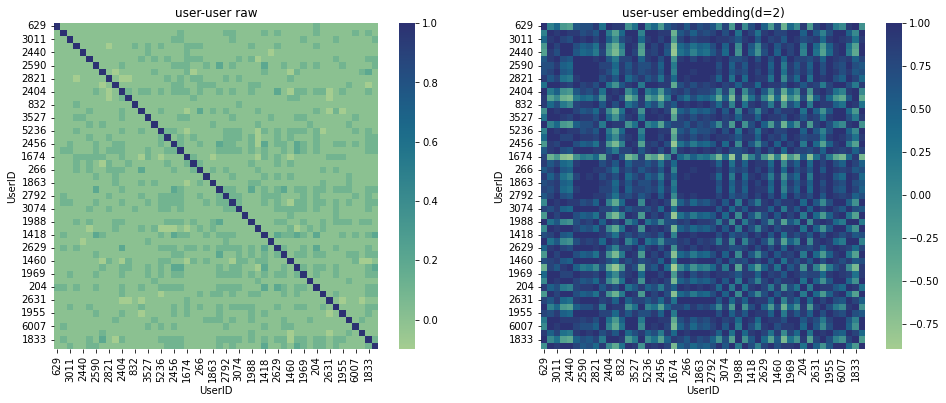


RMSE between user-user raw and user-user embedding(d=2): 0.7231652591029766
Distribution of user-user raw - user-user embedding(d=2)


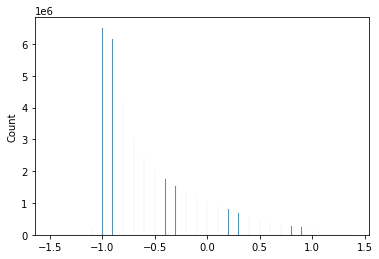

In [156]:
#visualize original(raw) and embeddings similarity matrices
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))

n=50 #subset size
for rec in sim_matrices:
  sm1, title1 = rec["sm1"]
  sm2, title2 = rec["sm2"]
  
  sm1_subset, user_indices = get_similarity_matrix_subset(sm1, n=n)
  sm2_subset, user_indices = get_similarity_matrix_subset(sm2, ids=user_indices, n=n)

  visualize_similarity_mat(sm1_subset, sm2_subset, title1=title1, title2=title2)

  sim1_values = sm1.values
  sim2_values = sm2.values

  rmse_err, mape_err = compute_error_metrics(sim1_values, sim2_values)
  print(f'\nRMSE between {title1} and {title2}: {rmse_err}')

  print(f'Distribution of {title1} - {title2}')
  sns.histplot(x=(sim1_values.ravel() - sim2_values.ravel()))
  plt.show()

**Observations:**

1. For a small random subset of 100 items (movies), we can visually observe that the Heatmap pattern for cosine similarity for the item embedding(d=4) is visually relatively similar to the heatmap pattern for original raw data. However, the pattern for item embedding(d=2) looks relatively less similar to the heatmap pattern for the original raw data. 

2. This visual observation can be confirmed through RMSE results between the original raw data and embeddings. RMSE score for item embedding(d=4) is 0.45, whereas for item embedding(d=2) is 0.56.

3. Similar observations can be made for user-user similarity matrices for embeddings(d=4) and embeddings(d=2). RMSE for user embedding(d=4) is 0.53, whereas for user embedding(d=2) is 0.72.

4. We also notice that the range of original cosine scores for items data is [-0.75, 1], and for users data is even narrower: [-0.2, ~0.25]. However, the range for all four embeddings; item/user, d4/d2, increases to increases to [-1,1]. The difference between the d=4 and d=2 embeddings is that shape of the distribution for d=4 embedding appears closer to original shape, while for d=2, it appears almost monotonically increasing. 



## User based approach to recommendations using Pearson correlation

**Approach Highlight:**

1. Create query user's profile (in terms of movie ratings)

2. **Candidate generation:** Find other users who’ve watched the same movies as the new user. Sort the old users by the count of most movies in common with the new user. Take the top 100 users and calculate a Similarity Score for each user using the Pearson Correlation function.

3. **Scoring:** Get the top 10 users with the highest similarity indices, all the movies for these users, and add Weighted movie Ratings by Multiplying the Rating to the Similarity Index. Calculate the average recommendation score by dividing the Weighted Rating by the Similarity Index and select movies with the highest score i.e., 5.

4. **Recommendation:** Now, recommend 10 movies based on the ratings given by old users who are similar to the new user.


In [167]:
#create binary utility matrix
utility_binary = (utility != 0).astype('int')
sparse_utility_binary = csr_matrix(utility_binary)

In [214]:
def user_based_recommendations(query_obj, topN=10):

  #candidate generation: find top 100 users sharing maximum rated movies with the query_object
  query_obj_binary = (query_obj != 0).astype('int')
  res = sparse_utility_binary.dot(query_obj_binary)
  candidates_df = pd.DataFrame({'dot_sim':res, 'pearson_sim': 0.0}, index=utility_binary.index).sort_values(by='dot_sim', ascending=False)[:100]

  #find pearson similarity for all candidates
  for i in range(candidates_df.shape[0]):
    candidate = utility.iloc[i].values
    corr, _ = pearsonr(query_obj, candidate)
    candidates_df.loc[candidates_df.index[i], 'pearson_sim'] = corr

  #take top 10 candidates
  candidates_df = candidates_df.sort_values(by=['pearson_sim', 'dot_sim'], ascending=[False, False])[:10]
  candidates = candidates_df.index.values

  #find all movies rated by these 10 candidates
  movies_rating_cnt = utility_binary.loc[candidates].sum(axis=0)
  candidate_movies = movies_rating_cnt[movies_rating_cnt > 0].index.values
  candidate_movie_ratings = utility.loc[candidates, candidate_movies]

  sim_vector = candidates_df['pearson_sim'].values
  sim_total = np.sum(sim_vector)
  
  #compute weighted recommendation score for each movie. Calculated as follow. 
  #each movie rating is multiplied by its rater's pearson similarity score.
  #all such ratings are added and finally divided by total of pearson similarity scores to get the final movie recommendation score.
  #we then sort movies in descending order by recommendation scores. 
  movie_rec_scores = (candidate_movie_ratings * sim_vector.reshape(-1,1)).sum(axis=0) / sim_total
  res = pd.DataFrame({'movie_id': candidate_movies, 'rec_score': movie_rec_scores}).sort_values(by='rec_score', ascending=False)
  
  #return top N movies with highest recommendation score
  return res[:topN]



**Example:** Find top 10 movie recommendations for a given user. For calculation purpose, we can consider our new user to have the same rating pattern as the user with userid 2.

In [223]:
#check profile for userid 2
userobj = utility.loc[2]
#check ratings (mean centered) given by the user
userobj[userobj != 0]

MovieID
21     -2.713178
95     -1.713178
110     1.286822
163     0.286822
165    -0.713178
          ...   
3678   -0.713178
3699   -1.713178
3735   -0.713178
3809   -0.713178
3893   -2.713178
Name: 2, Length: 129, dtype: float64

In [219]:
#build user query obj
user_query_obj = utility.loc[2].values
#get recommendations
rec_movies = user_based_recommendations(user_query_obj, topN=10)
rec_movies

,movie_id,rec_score
MovieID,,
318,318,1.208846
593,593,1.140816
1196,1196,0.970207
1954,1954,0.964962
1945,1945,0.960524
480,480,0.956470
1784,1784,0.949768
1193,1193,0.948306
1247,1247,0.907990


In [227]:
#show recommended movie details
rec_movies.merge(movies, left_index=True, right_on='MovieID')

,movie_id,rec_score,MovieID,Title,Genres,release_year
315,318,1.208846,318,"Shawshank Redemption, The (1994)",Drama,1994
589,593,1.140816,593,"Silence of the Lambs, The (1991)",Drama|Thriller,1991
1178,1196,0.970207,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War,1980
1885,1954,0.964962,1954,Rocky (1976),Action|Drama,1976
1876,1945,0.960524,1945,On the Waterfront (1954),Crime|Drama,1954
476,480,0.956470,480,Jurassic Park (1993),Action|Adventure|Sci-Fi,1993
1726,1784,0.949768,1784,As Good As It Gets (1997),Comedy|Drama,1997
1176,1193,0.948306,1193,One Flew Over the Cuckoo's Nest (1975),Drama,1975
1227,1247,0.907990,1247,"Graduate, The (1967)",Drama|Romance,1967
1239,1259,0.898699,1259,Stand by Me (1986),Adventure|Comedy|Drama,1986


## Case study Questionnaire:

**1. Users of which age group have watched and rated the most number of movies?**

In [122]:
df_temp = users.merge(ratings ,on='UserID')
df_temp.groupby('Age')['Rating'].agg(['count', 'mean'])

,count,mean
Age,,
18-24,183536,3.507573
25-34,395556,3.545235
35-44,199003,3.618162
45-49,83633,3.638062
50-55,72490,3.714512
56+,38780,3.766632
Under 18,27211,3.549520


This shows that users in 25-34 group have rated highest number of movies.


**2. Users belonging to which profession have watched and rated the most movies?**



In [123]:
df_temp.groupby('Occupation')['Rating'].agg('count').sort_values()

Occupation
farmer                    2706
homemaker                11345
tradesman/craftsman      12086
retired                  13754
unemployed               14904
lawyer                   20563
customer service         21850
scientist                22951
K-12 student             23290
clerical/admin           31623
doctor/health care       37205
self-employed            46021
sales/marketing          49109
artist                   50068
programmer               57214
writer                   60397
technician/engineer      72816
academic/educator        85351
executive/managerial    105425
other                   130499
college/grad student    131032
Name: Rating, dtype: int64

college/grad student -  131032

**3. Most of the users in our dataset who’ve rated the movies are Male. (T/F)**


In [124]:
df_temp.groupby('Gender')['Rating'].count()

Gender
0    246440
1    753769
Name: Rating, dtype: int64

In [125]:
df_temp.groupby('Gender')['UserID'].nunique()

Gender
0    1709
1    4331
Name: UserID, dtype: int64

We encoded Male as 1 and Female as 0. Thus the majority of the users who rated movies are Males.

**4. Most of the movies present in our dataset were released in which decade?**

**70s b. 90s c. 50s d.80s**



In [126]:
m.groupby('release_year')['MovieID'].nunique().sort_values(ascending=False)

release_year
1996    345
1995    342
1998    337
1997    315
1999    283
       ... 
1923      3
1919      3
1920      2
1922      2
1921      1
Name: MovieID, Length: 81, dtype: int64

Maximum movies (345) were released in year 1996.

**5. The movie with maximum no. of ratings is ___.**


In [127]:
movie_rating_cnt = ratings.groupby(['MovieID'])['Rating'].count().sort_values(ascending=False)
movie_rating_cnt

MovieID
2858    3428
260     2991
1196    2990
1210    2883
480     2672
        ... 
3237       1
763        1
624        1
2563       1
3290       1
Name: Rating, Length: 3706, dtype: int64

In [128]:
movies[movies['MovieID'] == movie_rating_cnt.index[0]]

,MovieID,Title,Genres,release_year
2789,2858,American Beauty (1999),Comedy|Drama,1999



**6. Name the top 3 movies similar to ‘Liar Liar’ on the item-based approach.**



In [129]:
#find movie id for 'Liar Liar'
movie_id = movies[movies['Title'].str.contains('Liar Liar')]['MovieID'].values[0]
movie_id

1485

In [130]:
#similar movies based on pearson correlation
res = find_similar_movies_pearson(query_id=movie_id, topN=3)
print(res)
movies[movies['MovieID'].isin(res['item'].values.tolist())]

Time taken:  13.497791528701782
      item   corr
2252  2321  0.993
1029  1042  0.989
1572  1614  0.986


,MovieID,Title,Genres,release_year
1029,1042,That Thing You Do! (1996),Comedy,1996
1572,1614,In & Out (1997),Comedy,1997
2252,2321,Pleasantville (1998),Comedy,1998


In [131]:
#similar movies based on cosine similarity 
res = find_similar_movies_cosine(query_id=movie_id, topN=3)
print(res)
movies[movies['MovieID'].isin(res['item'].values.tolist())]

Time taken:  0.004807710647583008
      item  similarity
775    785       0.999
102    104       0.999
1029  1042       0.999


,MovieID,Title,Genres,release_year
102,104,Happy Gilmore (1996),Comedy,1996
775,785,Kingpin (1996),Comedy,1996
1029,1042,That Thing You Do! (1996),Comedy,1996


**7. On the basis of approach, Collaborative Filtering methods can be classified into ___-based and ___-based.**


item-item similarity based and user-user similarity based


**8. Pearson Correlation ranges between ___ to ___ whereas, Cosine Similarity belongs to the interval between ___ to ___.**



The range for both Pearson correlation and Cosine similarity is -1 to 1, where -1 indicates completely opposite vectors, 0 indicates orthogonal (uncorrelated) vectors, and 1 indicates identical vectors.

**9. Mention the RMSE and MAPE that you got while evaluating the Matrix Factorization model.**



In [132]:
print(f'Train RMSE: {train_rmse_err}, MAPE: {train_mape_err}')
print(f'Test RMSE: {test_rmse_err}, MAPE: {test_mape_err}')

Train RMSE: 1.2040033339668108, MAPE: 0.3367440105074651
Test RMSE: 0.9205173609568992, MAPE: 0.24883384329253652


**10. Give the sparse ‘row’ matrix representation for the following dense matrix -**

[[1 0]
[3 7]]

In [134]:
dense_mat = np.array([[1, 0], [3, 7]])
sparse_row_mat = csr_matrix(dense_mat)
sparse_row_mat

<2x2 sparse matrix of type '<class 'numpy.int64'>'
	with 3 stored elements in Compressed Sparse Row format>